# Testing effect Whitening Transform on encoders

This file collects a series of experiments.
The following experiments can be found below:
1. **Training encoders to minimizing distance between related images**
    One encoder is trained using the W-MSE loss, the other with the normal MSE loss.
    The resulting latent spaces are plotted using t-SNE,
    and a numerical heatmap is computed.
    
    Can we see a difference in organization of the latent spaces?

In [16]:
import torch
from torch import Tensor
import torchvision as vision
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_tensor

from typing import Optional
import os
import time
import pickle
import itertools
import collections

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import numpy as np
from scipy.signal import savgol_filter
from sklearn.manifold import TSNE

from rolim.encoder.train_enc import train_encoder
from rolim.encoder.pairwise_sampler import get_n_images_each_class
from rolim.settings import CIFAR10_DIR, RNG, DEVICE

## Experiment 1: Training encoders to minimizing distance between related images
Start with training the networks.
Because I rerun this notebook quite often,
I cache saved trained networks and load them again,
to avoid retraining them every time.

In [2]:
def get_timestamp() -> str:
    return time.strftime("%Y-%m-%d___%H-%M")

In [3]:
rerun = False
if rerun: # Avoid long training when trained networks already saved to disk
    (encoder_whitening, losses_whitening) = train_encoder("distance", use_whitening=True, num_batches=2000)
    (encoder_pure, losses_pure) = train_encoder("distance", use_whitening=False, num_batches=2000)

    timestamp = get_timestamp()
    torch.save(encoder_whitening, timestamp + "enc_whitened.pt")
    with open(timestamp + "loss_whitened.pickle", "wb") as f:
        pickle.dump(losses_whitening, f)

    torch.save(encoder_pure, timestamp + "enc_no_whit.pt")
    with open(timestamp + "loss_no_whit.pickle", "wb") as f:
        pickle.dump(losses_pure, f)
else:
    encoder_whitening = torch.load("2022-11-08___21-34enc_whitened.pt")
    with open("2022-11-08___21-34loss_whitened.pickle", "rb") as f:
        losses_whitening = pickle.load(f)
    encoder_pure = torch.load("2022-11-08___21-34enc_no_whit.pt")
    with open("2022-11-08___21-34loss_no_whit.pickle", "rb") as f:
        losses_pure = pickle.load(f)

### Learning curves
Note that this is **NOT** a fair comparison of performance,
since the W-MSE loss scales the magnitude of distances between images.

However, we can see that each encoder converges quite quickly.

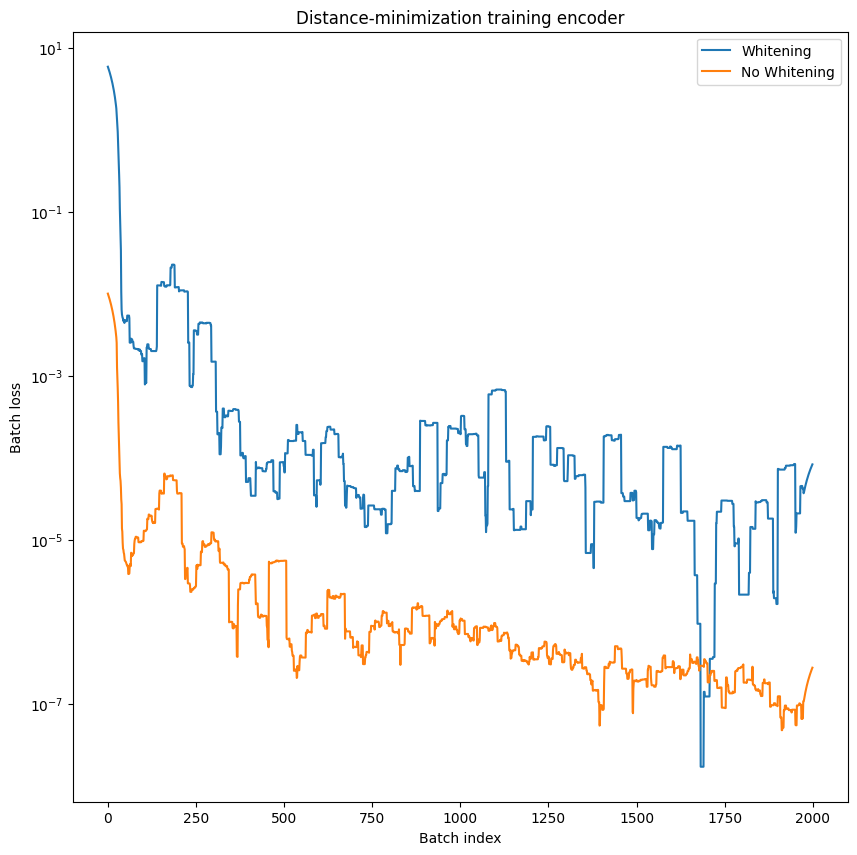

In [4]:
def plot_losses(losses_lists: list[list[int]], 
                labels:list[str],
                apply_smoothing:bool=True):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    for losses, label in zip(losses_lists, labels):
        if apply_smoothing:
            losses = __smooth_savgol(losses)
        ax.semilogy(losses, label=label)

    ax.set_title("Distance-minimization training encoder")
    ax.set_xlabel("Batch index")
    ax.set_ylabel("Batch loss")
    ax.legend()

def __smooth_savgol(vector: np.ndarray, smoothing_window: int = 50) -> np.ndarray:
    return savgol_filter(vector, smoothing_window, polyorder=1)

plot_losses(
    (losses_whitening,losses_pure),
    ("Whitening", "No Whitening")
)
    

In [8]:
IMAGES_PER_CLASS = 50
testset = vision.datasets.CIFAR10(root=CIFAR10_DIR, train=False, 
                                       download=False, transform=to_tensor)
with torch.no_grad():
    test_images = get_n_images_each_class(IMAGES_PER_CLASS, testset)
    test_images = [torch.stack([image 
                   for image in images], dim=0).to(DEVICE)
                   for images in test_images]

    # Note: no whitening at inference time.
    # Name only includes whitening to refer to the network
    # previous trained while using whitening.
    encodings_whit_net = [encoder_whitening(batch) for batch in test_images]
    encodings_pure_net = [encoder_pure(batch) for batch in test_images]

# Mean values for the encodings of the first class:
print(torch.mean(encodings_whit_net[0]))
print(torch.mean(encodings_pure_net[0]))


tensor(0.0045, device='cuda:0')
tensor(-0.0017, device='cuda:0')


Interpreting the data as 500 sampleseach of length 32.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000000


/home/nifrec/.pyenv/versions/3.10_default/envs/rolim/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 31.609390
[t-SNE] KL divergence after 1000 iterations: -1.700310
(500, 2)
Interpreting the data as 500 sampleseach of length 32.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000000


/home/nifrec/.pyenv/versions/3.10_default/envs/rolim/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.104362
[t-SNE] KL divergence after 1000 iterations: 0.470944
(500, 2)


[(-300.0, 300.0), (-300.0, 300.0)]

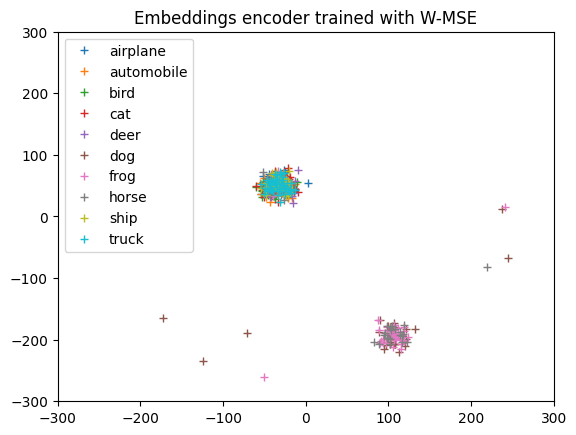

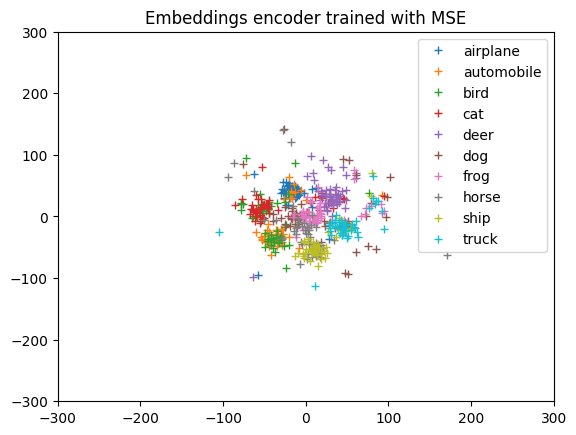

In [13]:
def make_tsne_plot(encodings_per_class: list[list[np.ndarray]], 
                   classes:list[str], 
                   ax: Optional[Axes]=None,
                   apply_jitter: bool=True
                   ) -> tuple[Axes, Figure|None]:
    """
    Plot the encodings in tSNE-dimension-reduced space,
    and colour the embedding according to their class.

    Arguments:
    * encodings_per_class: list of encodings for each class.
    * classes: list of class labels, such that the label has the index
        of the corresponding encodings in `encodings_per_class`.
        Used for the plot legend.
    * ax: optional ax to plot the figure in.
    * apply_jitter: whether or not to randomly translate the embeddings
        a little with standard normal Gaussian noise (scaled by a factor 10).

    Returns:
    * Axes instance holding the plot.
    * figure holding the Axes, unless the `ax` argument is used,
        then `None`.
    """
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)
    else:
        fig = None

    assert len(encodings_per_class) == len(classes)

    tsne = TSNE(n_components=2, 
                learning_rate="auto", 
                init="pca",
                # perplexity=12,
                # early_exaggeration=5,
                verbose=1)

    # Unfortunately, we cannot first fit the tSNE and then apply it
    # to the encodings of each class separately.
    # So we have to regroup the output in classes again.
    # (Expected shape input TSNE: (num_samples, num_features)).
    all_encodings = np.concatenate(encodings_per_class, axis=0)
    print(f"Interpreting the data as {all_encodings.shape[0]} samples"
          f"each of length {all_encodings.shape[1]}.")
    dim_reduced_encodings = tsne.fit_transform(all_encodings)
    print(dim_reduced_encodings.shape)

    if apply_jitter:
        dim_reduced_encodings = jitter_data(RNG, 10, dim_reduced_encodings)

    for class_idx in range(len(classes)):
        num_encodings = len(encodings_per_class[class_idx])
        encodings_curr_class = dim_reduced_encodings[:num_encodings]
        dim_reduced_encodings = dim_reduced_encodings[num_encodings:]
        label = classes[class_idx]
        ax.plot(encodings_curr_class[:, 0], 
                encodings_curr_class[:, 1],
                "+",
                label=label)
    assert len(dim_reduced_encodings) == 0, \
        f"Bug: encodings not plotted: {dim_reduced_encodings}"

    ax.legend()

    return ax, fig

def nested_tensors_to_np(tensors: list[list[Tensor]]) -> list[list[np.ndarray]]:
    output = [[tensor.cpu().numpy() for tensor in nested_list]
              for nested_list in tensors]
    return output

def jitter_data(rng: np.random.Generator, scale: float, data: np.ndarray) -> np.ndarray:
    noise = rng.standard_normal(size=data.shape)*scale
    return data+noise

classes = testset.classes
limits = {"xlim":[-300, 300], "ylim":[-300, 300]}
ax_whit, fig_whit = make_tsne_plot(nested_tensors_to_np(encodings_whit_net),
                        classes)
ax_whit.set_title("Embeddings encoder trained with W-MSE")
ax_whit.set(**limits)

ax_pure, fig_pure = make_tsne_plot(nested_tensors_to_np(encodings_pure_net),
                        classes)
ax_pure.set_title("Embeddings encoder trained with MSE")
ax_pure.set(**limits)

In [19]:
prefix = os.path.join("figures", "dist_minim_tsne")
if not os.path.exists(prefix):
    os.makedirs(prefix)
    
timestamp = get_timestamp()
fig_whit.savefig(os.path.join(prefix, timestamp+"__whit.pdf"))
fig_whit.savefig(os.path.join(prefix, timestamp+"__pure.pdf"))

##### Whitened Encoder t-SNE
First of all, tSNE for the whitened encoder 
converged to mapping the clusters
to practically exactly the same point. I added jitter
(random Gaussian translations) to reveal more of the
composition of the clusters.

I tried a lot of different values of `perplexity`
and `early_exaggeration`, both keep the large mixed cluster
in which most samples fall. Using `random` initialization
resulted in more or less 1 point, with `pca` some clustering
is still detected.

When using `pca`, the big cluster is the `(0, 0)` cluster.
So does this provide evidence that the encoders partially
converged to constant output?
Either way, tSNE maps most encodings to `(0, 0)`,
which doesn't imply any interesting organization of the latent space.

##### Normal Encoder t-SNE
Data points are much less cluttered in one big point.
Instead, we can detect some clusters for some classes.
However, this does not hold for all classes, some
seem very scattered thoughout the embedding.